# Description

This notebook presents the reporting function for random forest models for classification tasks, using the scikit-learn package.

It consists of the permutation feature importance (for individual and group features), confusion matrix, and classification report using stratified cross validation.

The input data include:
```
X: a data.frame of predictor variables
y: a 1-D numpy ndarray of response variables.
dict_list_group_var**: a dictionary consisting of feature group names and features, e.g. 
{'group_1':['A', 'B', 'C'], 'group2':['D', 'E']}
```

The outputs include:
- **df_avg_imp_feature**: a dataframe that represents the importance of individual variables
- **df_avg_imp_group_feature**: a dataframe that represents the importance of group variables

# Loading packages and dataset

In [1]:
from sklearn.model_selection import StratifiedKFold
import rfpimp
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_wine
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score, cross_val_predict
import pandas as pd 
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

%matplotlib inline

C:\Users\Huanfa Chen\Anaconda3\envs\test_tf\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
# define X, Y, list_group_var
# here we use the wine dataset for demonstration
data = load_wine()

X = data.data
y = data.target

X_column_name = data.feature_names

# groups of X variables for demonstration. The grouping is not meaningful though
dict_list_group_var = {'group_1':data.feature_names[0:3], 'group_2':data.feature_names[3:6], 'group_3':data.feature_names[6:]}

# number of cv folds
cv_fold = 10
# random_state of StratifiedKFold
random_seed = 10

In [3]:
# objects for saving the result
list_train_accuracy = []
list_test_accuracy = []
list_y_test_true = []
list_y_test_pred = []
list_df_importance_individual_feature = []
list_df_importance_group_feature = []

# Random forest models using cross validation

In [4]:
# Note that the output of StratifiedKFold is numpy.ndarray, which needs to be transformed to data.frame before feeding into RandomForestClassifier.fit()
# There are three different ways to do cross validation in sklearn. The way using StratifiedKFold is adopted here as the feature importance is computed in each iteration

skf = StratifiedKFold(n_splits=cv_fold, shuffle=True, random_state=random_seed)
print(skf)

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # transform numpy.ndarray to dataframe
    X_train = pd.DataFrame(X_train, columns=X_column_name)
    X_test = pd.DataFrame(X_test, columns=X_column_name)
    
    rf = RandomForestClassifier()
    rf.fit(X_train, y_train)
    
    # append the accuracy to the lists
    list_train_accuracy.append(rf.score(X_train, y_train))
    list_test_accuracy.append(rf.score(X_test, y_test))
    
    # append the true and predicted labels of the validation set
    list_y_test_true = list_y_test_true + y_test.tolist()
    list_y_test_pred = list_y_test_pred + rf.predict(X_test).tolist()
    
    # append the feature importance
    list_df_importance_individual_feature.append(rfpimp.importances(rf, X_test, y_test))
    imp_group_vars = rfpimp.importances(rf, X_test, y_test, features = [dict_list_group_var[x] for x in dict_list_group_var], n_samples=-1)
    # reset index
    imp_group_vars = imp_group_vars.reset_index()
    # change the group name
    imp_group_vars.loc[:,'Feature'] = dict_list_group_var.keys()
    list_df_importance_group_feature.append(imp_group_vars)

StratifiedKFold(n_splits=10, random_state=10, shuffle=True)


# Permutation feature importance

In [18]:
# Here, the permutation feature importance is the avearge of all iterations. Alternatively, the permutation feature importance can be computed using one-round of train-test plit and on the testing data.The latter approach would be more efficient.

# post processing the feature importance
# compute the average across all iterations. Rename the variables as needed
# concatenate all data frames
comb_df_importance_individual_feature = pd.concat(list_df_importance_individual_feature)
# group by 'Feature' and take the average
df_avg_imp_feature = comb_df_importance_individual_feature.groupby(['Feature']).mean()

# sort by the importance in an descending order, reset index
df_avg_imp_feature = df_avg_imp_feature.sort_values(by=['Importance'], ascending=False).reset_index()
print('Importance of individual variables')
print(df_avg_imp_feature)

# deal with group variables
comb_df_importance_group_feature = pd.concat(list_df_importance_group_feature)
df_avg_imp_group_feature = comb_df_importance_group_feature.groupby(['Feature']).mean()
# sort by the importance in an descending order, reset index
df_avg_imp_group_feature = df_avg_imp_group_feature.sort_values(by=['Importance'], ascending=False).reset_index()

print('*****************************')
print('Importance of group variables')
print(df_avg_imp_group_feature)

Importance of individual variables
                         Feature  Importance
0                        proline    0.073856
1                color_intensity    0.073529
2                     flavanoids    0.033987
3                        alcohol    0.022876
4              alcalinity_of_ash    0.000000
5                            ash    0.000000
6                      magnesium    0.000000
7                     malic_acid    0.000000
8           nonflavanoid_phenols    0.000000
9                proanthocyanins    0.000000
10                 total_phenols    0.000000
11                           hue   -0.000327
12  od280/od315_of_diluted_wines   -0.005556
*****************************
Importance of group variables
   Feature  Importance
0  group_1    0.415359
1  group_2    0.033987
2  group_3    0.000000


13


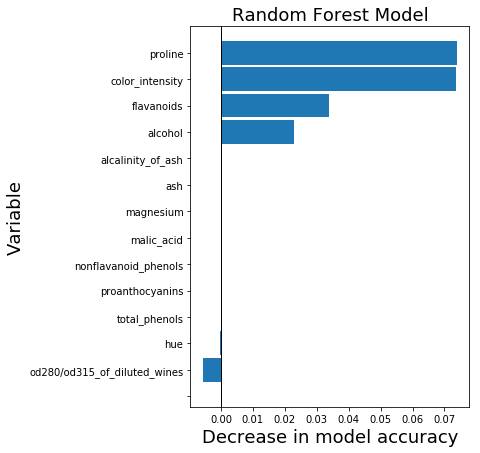

In [19]:
# plotting feature importance using horizontal bar plots and only one colour

# print(df_avg_imp_feature)
num_feature = df_avg_imp_feature.shape[0]
print(num_feature)
fig, ax = plt.subplots(1, figsize=(5,7))
ax.barh(df_avg_imp_feature.index, df_avg_imp_feature['Importance'], height=0.9)
ax.set_yticks(ticks=np.arange(0,29,1))
ax.set_yticklabels(labels=df_avg_imp_feature['Feature'])
# ax.set_xlim(-.005,.03)
ax.set_ylim(-1, float(num_feature) + 0.4)
ax.vlines(0,-1,float(num_feature) + 0.6, linewidth=1)

ax.set_xlabel("Decrease in model accuracy",size=18)

ax.invert_yaxis();
ax.set_ylabel("Variable",size=18)
ax.set_title("Random Forest Model", size=18)
plt.subplots_adjust(wspace=0.1)

# saving the plot as an image file
# plt.savefig('../../other/images/feat_imp.tif',bbox_inches='tight',dpi = 300)

['alcohol', 'malic_acid', 'ash']
['alcalinity_of_ash', 'magnesium', 'total_phenols']
['flavanoids', 'nonflavanoid_phenols', 'proanthocyanins', 'color_intensity', 'hue', 'od280/od315_of_diluted_wines', 'proline']


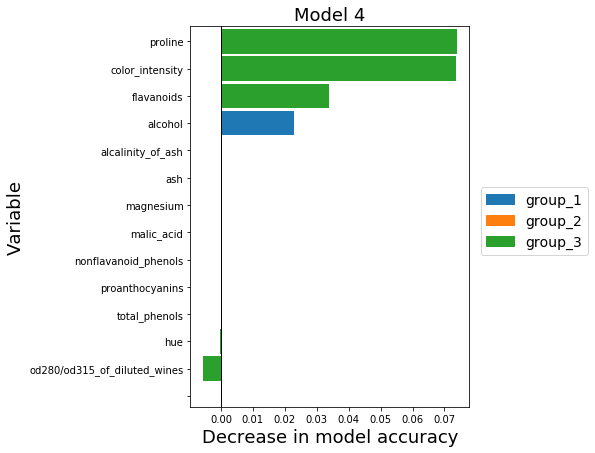

In [17]:
# feature importance plots using different colours for different groups
# the code is not working. See this link: https://stackoverflow.com/questions/44493417/pandas-dataframe-bar-plot-plot-bars-different-colors-from-specific-colormap

list_col = ['C0', 'C1', 'C2']

num_feature = df_avg_imp_feature.shape[0]
fig, ax = plt.subplots(1, figsize=(5,7))
# lt_mask = feat_imp['Feature'].str.contains('LT_')
# g_mask = feat_imp['Feature'].str.contains('G_')

list_legend_elements = []
for (feature_group, features), color in zip(dict_list_group_var.items(), list_col):
    print(features)
    df_subset = df_avg_imp_feature[df_avg_imp_feature['Feature'].isin(features)]
    ax.barh(df_subset.index, df_subset['Importance'], height=0.9)
    list_legend_elements.append(mpatches.Patch(facecolor=color, edgecolor=color))

# plt.barh(feat_imp[~lt_mask]['Feature'].index, feat_imp[~lt_mask]['Importance'], height=0.9)
ax.set_yticks(ticks=np.arange(0,29,1))
ax.set_yticklabels(labels=df_avg_imp_feature['Feature'])
# ax.set_xlim(-.005,.03)
ax.set_ylim(-0.55,num_feature + 0.4)
ax.vlines(0,-0.6,num_feature + 0.5, linewidth=1)

ax.set_xlabel("Decrease in model accuracy",size=18)

ax.invert_yaxis();
ax.set_ylabel("Variable",size=18)
ax.set_title("Model 4", size=18)
plt.subplots_adjust(wspace=0.1)

plt.legend(list_legend_elements,dict_list_group_var.keys(),fontsize=14, loc=(1.04,0.4))
# plt.savefig('../../other/images/feat_imp.tif',bbox_inches='tight',dpi = 300)

3


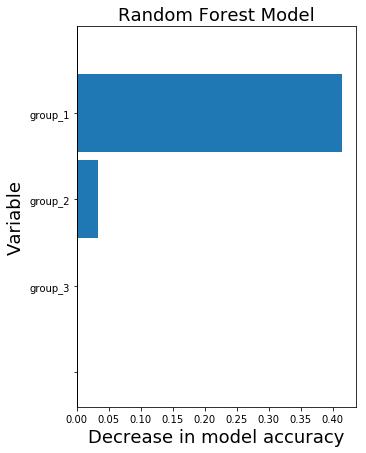

In [8]:
# group feature importance
num_feature = df_avg_imp_group_feature.shape[0]
df_feature_imp = df_avg_imp_group_feature

print(num_feature)
fig, ax = plt.subplots(1, figsize=(5,7))
ax.barh(df_feature_imp.index, df_feature_imp['Importance'], height=0.9)
ax.set_yticks(ticks=np.arange(0,29,1))
ax.set_yticklabels(labels=df_feature_imp['Feature'])
# ax.set_xlim(-.005,.03)
ax.set_ylim(-1, float(num_feature) + 0.4)
ax.vlines(0,-1,float(num_feature) + 0.6, linewidth=1)

ax.set_xlabel("Decrease in model accuracy",size=18)

ax.invert_yaxis();
ax.set_ylabel("Variable",size=18)
ax.set_title("Random Forest Model", size=18)
plt.subplots_adjust(wspace=0.1)

del df_feature_imp

# Confusion matrix

In [9]:
# post precessing the confusion matrix
conf_mat = confusion_matrix(list_y_test_true, list_y_test_pred)
print('The accumulative confusion matrix')
print(pd.DataFrame(conf_mat))
print('The accumulative report')
print(classification_report(list_y_test_true, list_y_test_pred))

The accumulative confusion matrix
    0   1   2
0  58   1   0
1   1  68   2
2   0   0  48
The accumulative report
              precision    recall  f1-score   support

           0       0.98      0.98      0.98        59
           1       0.99      0.96      0.97        71
           2       0.96      1.00      0.98        48

    accuracy                           0.98       178
   macro avg       0.98      0.98      0.98       178
weighted avg       0.98      0.98      0.98       178



In [20]:
# Another way to compute cross-validated confusion matrix using cross_val_score

skf = StratifiedKFold(n_splits=cv_fold, shuffle=True, random_state=random_seed)
print("Cross validation splittor: ", skf)

# output accuracy
rf = RandomForestClassifier()
scores = cross_val_score(rf, X, y, cv=skf)

print("Cross validation score [mean(std)]: %0.4f (+/-%0.4f)" % (np.mean(scores), np.std(scores)))

# output the accumulative confusion matrix
y_pred = cross_val_predict(rf, X, y, cv=skf)
conf_mat = confusion_matrix(y, y_pred)
print('******************')
print('The accumulative confusion matrix')
print(pd.DataFrame(conf_mat))
print('******************')
print('The accumulative report')
print(classification_report(y, y_pred))

Cross validation splittor:  StratifiedKFold(n_splits=10, random_state=10, shuffle=True)
Cross validation score [mean(std)]: 0.9775 (+/-0.0276)
******************
The accumulative confusion matrix
    0   1   2
0  58   1   0
1   1  68   2
2   0   0  48
******************
The accumulative report
              precision    recall  f1-score   support

           0       0.98      0.98      0.98        59
           1       0.99      0.96      0.97        71
           2       0.96      1.00      0.98        48

    accuracy                           0.98       178
   macro avg       0.98      0.98      0.98       178
weighted avg       0.98      0.98      0.98       178

